# Gold Price: Seasonality and Calendar Effects

This notebook investigates seasonality and calendar effects in gold returns and identifies calendar-derived features that may improve forecasting.

**Scope**
- Decompose series into trend/seasonal/residual components
- Analyze return behavior by month, day-of-week, and year-month panels
- Run simple statistical tests (Welch t-tests + bootstrap confidence intervals)
- Recommend practical calendar features for downstream forecasting models

In [1]:
import os
import warnings
from pathlib import Path

os.environ.setdefault("MPLCONFIGDIR", "/tmp/mpl-cache")
os.environ.setdefault("XDG_CACHE_HOME", "/tmp/xdg-cache")

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, f_oneway, kruskal
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.multitest import multipletests

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

RNG = np.random.default_rng(42)
DATA_PATH = Path("gold_historical_data.csv")

In [2]:
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH.resolve()}")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)

df["Return"] = df["Close"].pct_change()
df["LogReturn"] = np.log(df["Close"]).diff()
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["MonthName"] = df["Date"].dt.strftime("%b")
df["Weekday"] = df["Date"].dt.day_name()

analysis_df = df.dropna(subset=["Return"]).copy()

print(f"Rows: {len(df):,}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Daily return observations: {len(analysis_df):,}")

df.head()

Rows: 2,510
Date range: 2016-02-05 to 2026-01-30
Daily return observations: 2,509


,Date,Adj Close,Close,High,Low,Open,Volume,Return,LogReturn,Year,Month,MonthName,Weekday
0,2016-02-05,"1,157.800049","1,157.800049","1,174.800049","1,146.000000","1,155.599976",877,NaN,NaN,2016,2,Feb,Friday
1,2016-02-08,"1,197.900024","1,197.900024","1,200.400024","1,165.000000","1,173.500000",931,0.034635,0.034048,2016,2,Feb,Monday
2,2016-02-09,"1,198.699951","1,198.699951","1,199.199951","1,186.699951","1,188.699951",700,0.000668,0.000668,2016,2,Feb,Tuesday
3,2016-02-10,"1,194.699951","1,194.699951","1,197.699951","1,182.099976","1,189.800049",671,-0.003337,-0.003343,2016,2,Feb,Wednesday
4,2016-02-11,"1,247.900024","1,247.900024","1,260.800049","1,204.599976","1,205.599976",995,0.044530,0.043567,2016,2,Feb,Thursday


## 1) Seasonality and Regime View (Monthly Return Heatmap)

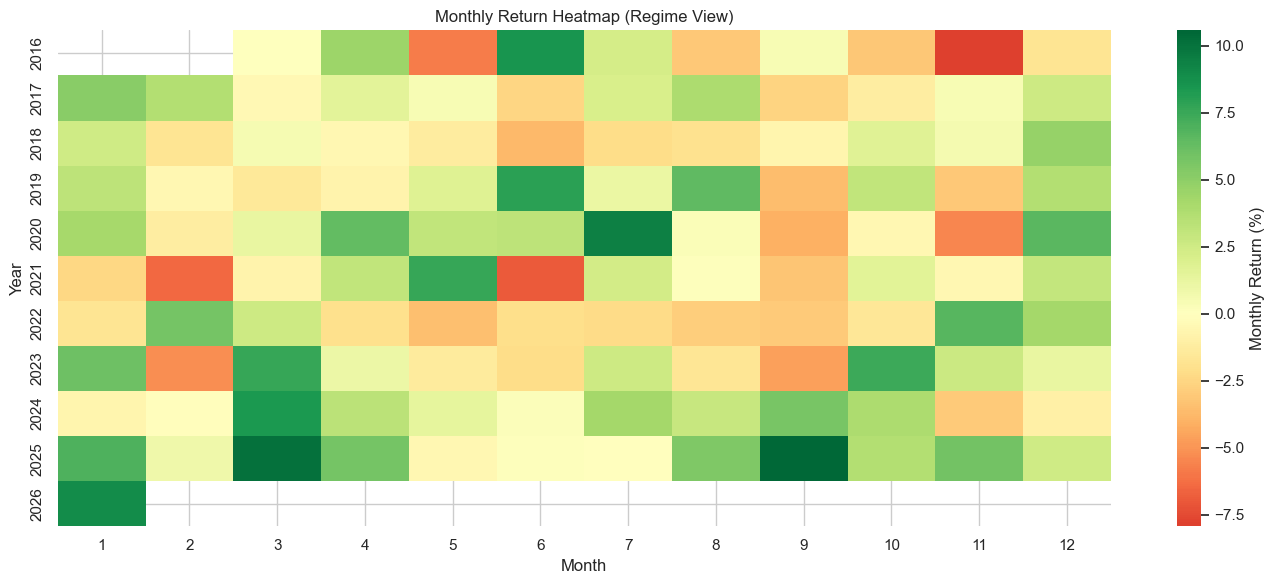

In [3]:
monthly_close = df.set_index("Date")["Close"].resample("ME").last()
monthly_ret = monthly_close.pct_change()

heat = monthly_ret.to_frame("MonthlyReturn")
heat["Year"] = heat.index.year
heat["Month"] = heat.index.month
heat_pivot = heat.pivot(index="Year", columns="Month", values="MonthlyReturn")

plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_pivot * 100,
    cmap="RdYlGn",
    center=0,
    annot=False,
    cbar_kws={"label": "Monthly Return (%)"},
)
plt.title("Monthly Return Heatmap (Regime View)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

## 2) Decomposition: Trend + Seasonal + Residual

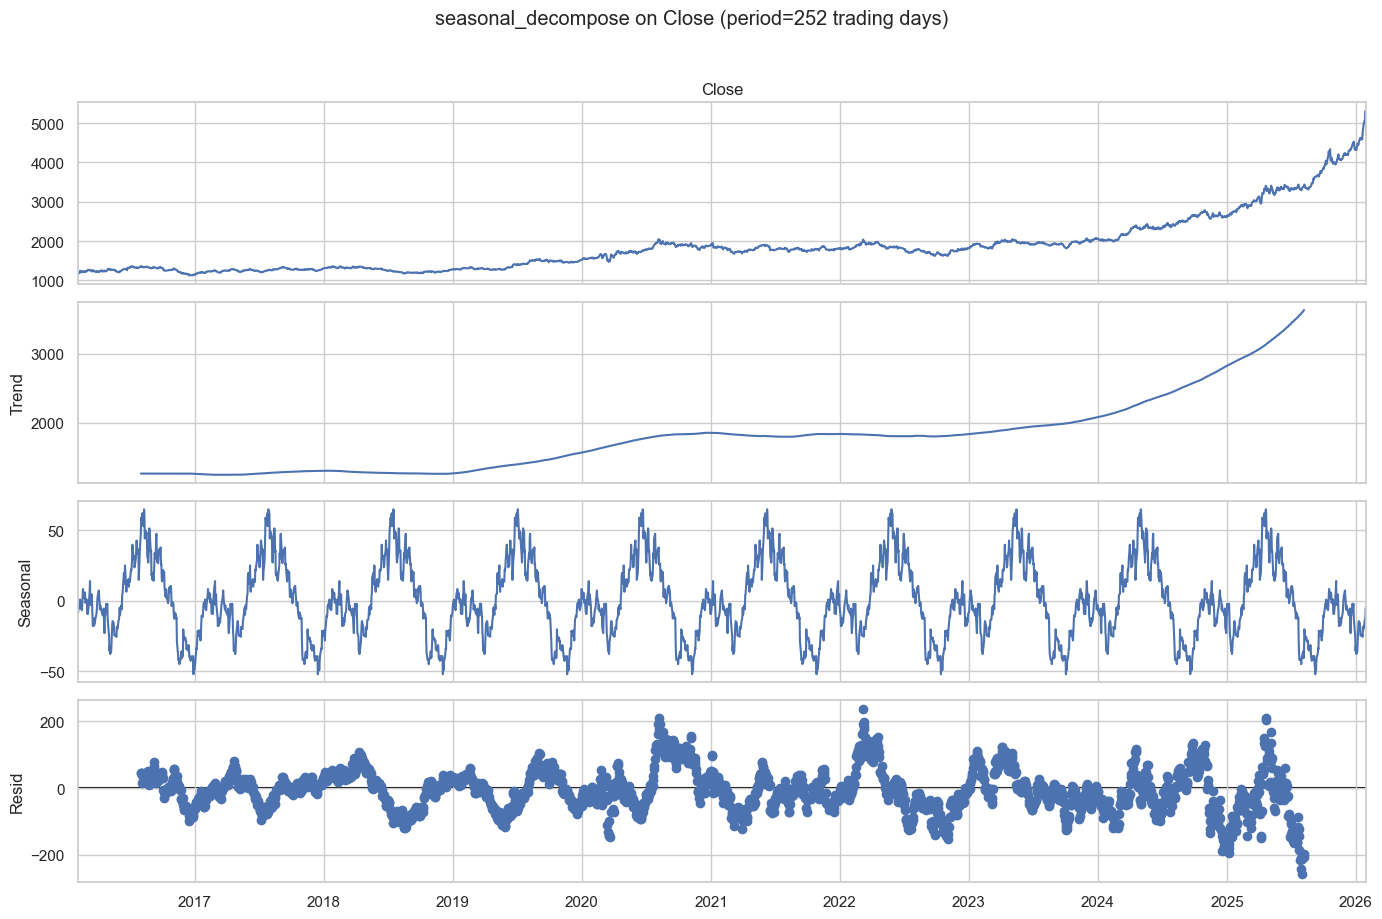

In [4]:
# seasonal_decompose needs a regular frequency; use business-day frequency with forward fill.
close_b = df.set_index("Date")["Close"].asfreq("B").ffill()

decomp = seasonal_decompose(close_b, model="additive", period=252)
fig = decomp.plot()
fig.set_size_inches(14, 9)
fig.suptitle("seasonal_decompose on Close (period=252 trading days)", y=1.02)
plt.tight_layout()
plt.show()

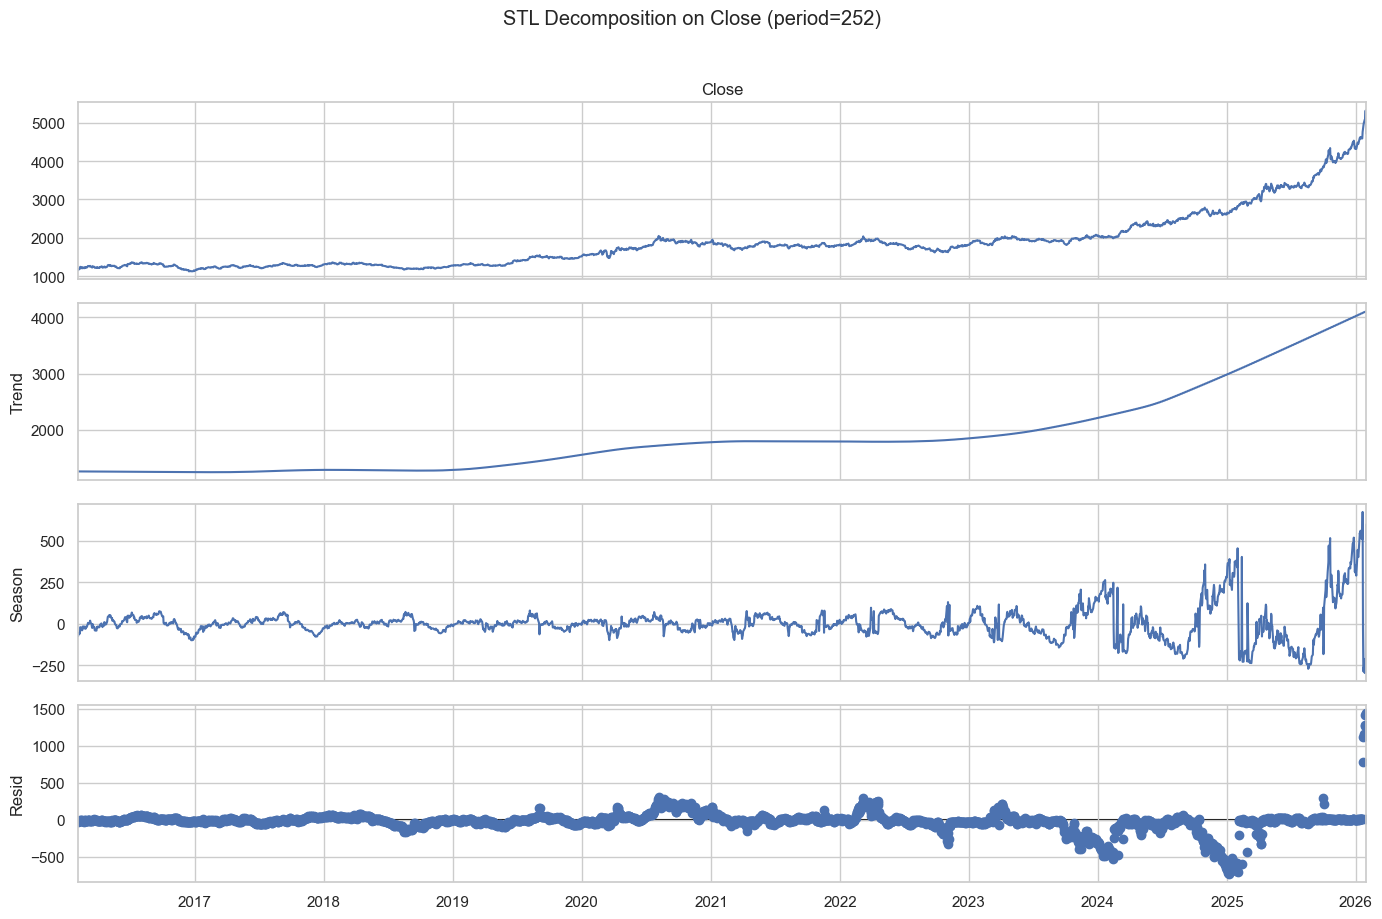

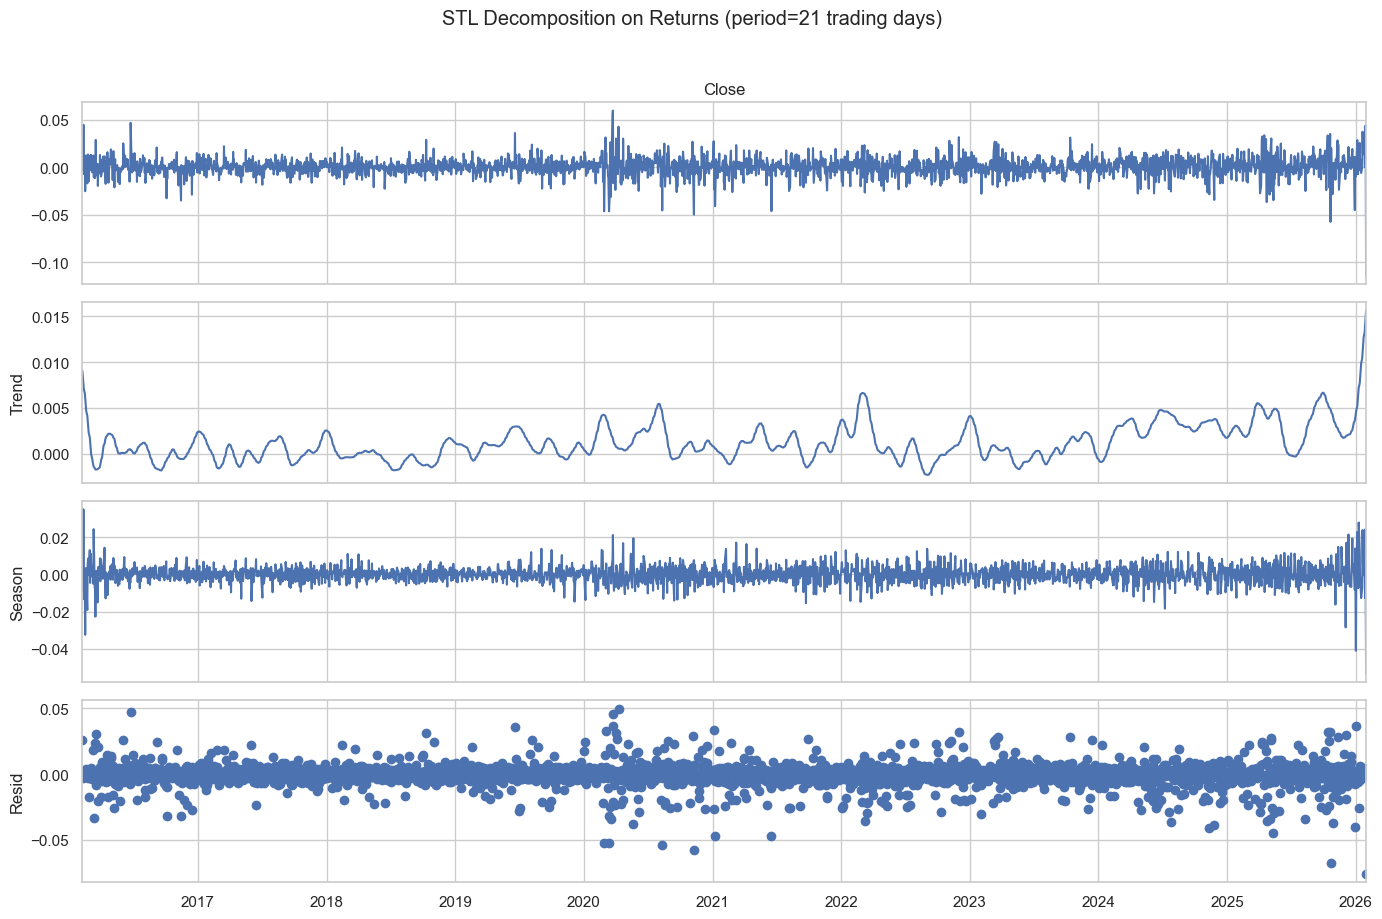

In [5]:
# STL is often more robust for financial series.
stl_close = STL(close_b, period=252, robust=True).fit()
fig = stl_close.plot()
fig.set_size_inches(14, 9)
fig.suptitle("STL Decomposition on Close (period=252)", y=1.02)
plt.tight_layout()
plt.show()

ret_b = close_b.pct_change().dropna()
stl_ret = STL(ret_b, period=21, robust=True).fit()
fig = stl_ret.plot()
fig.set_size_inches(14, 9)
fig.suptitle("STL Decomposition on Returns (period=21 trading days)", y=1.02)
plt.tight_layout()
plt.show()

## 3) Calendar Effects: Month-of-Year

In [6]:
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
analysis_df["MonthName"] = pd.Categorical(analysis_df["MonthName"], categories=month_order, ordered=True)

month_stats = (
    analysis_df.groupby(["Month", "MonthName"]) ["Return"]
    .agg(mean="mean", median="median", std="std", count="count")
    .reset_index()
    .sort_values("Month")
)
month_stats["se"] = month_stats["std"] / np.sqrt(month_stats["count"])
month_stats["ci95_low"] = month_stats["mean"] - 1.96 * month_stats["se"]
month_stats["ci95_high"] = month_stats["mean"] + 1.96 * month_stats["se"]
month_stats

,Month,MonthName,mean,median,std,count,se,ci95_low,ci95_high
0,1,Jan,0.001607,0.001931,0.012425,203,0.000872,-0.000102,0.003316
11,1,Dec,NaN,NaN,NaN,0,NaN,NaN,NaN
10,1,Nov,NaN,NaN,NaN,0,NaN,NaN,NaN
9,1,Oct,NaN,NaN,NaN,0,NaN,NaN,NaN
7,1,Aug,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
133,12,Feb,NaN,NaN,NaN,0,NaN,NaN,NaN
132,12,Jan,NaN,NaN,NaN,0,NaN,NaN,NaN
142,12,Nov,NaN,NaN,NaN,0,NaN,NaN,NaN
136,12,May,NaN,NaN,NaN,0,NaN,NaN,NaN


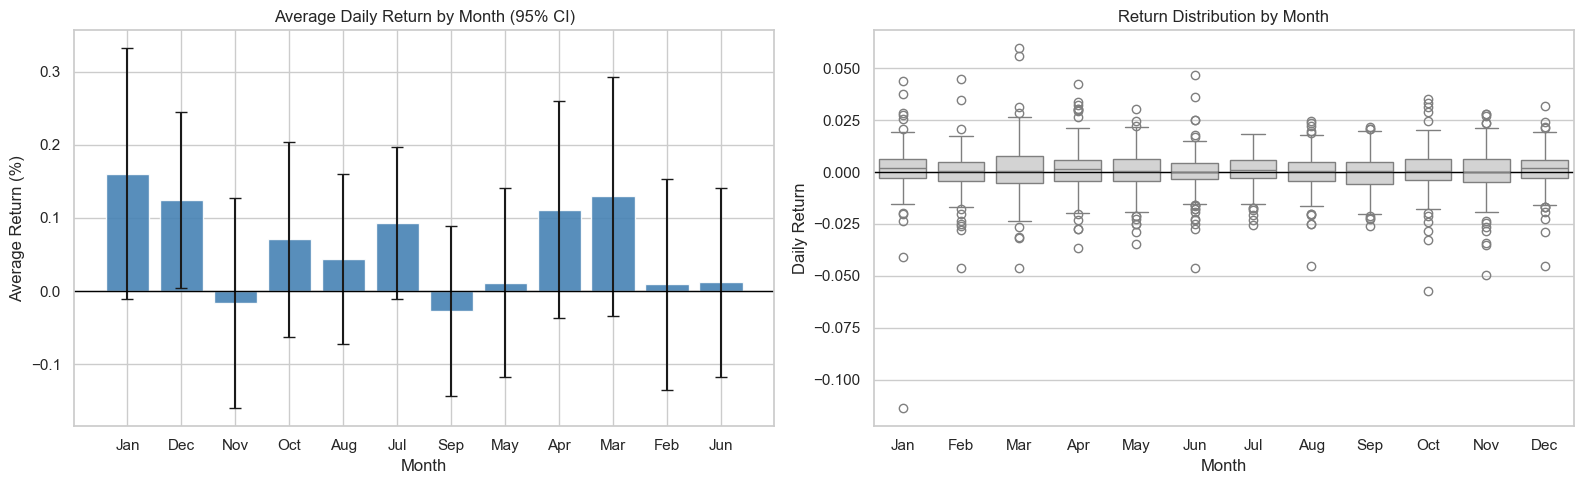

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(
    month_stats["MonthName"].astype(str),
    month_stats["mean"] * 100,
    yerr=1.96 * month_stats["se"] * 100,
    color="steelblue",
    alpha=0.9,
    capsize=4,
)
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("Average Daily Return by Month (95% CI)")
axes[0].set_ylabel("Average Return (%)")
axes[0].set_xlabel("Month")

sns.boxplot(
    data=analysis_df,
    x="MonthName",
    y="Return",
    ax=axes[1],
    color="lightgray",
)
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Return Distribution by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Daily Return")

plt.tight_layout()
plt.show()

## 4) Calendar Effects: Day-of-Week

In [8]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
analysis_df["Weekday"] = pd.Categorical(analysis_df["Weekday"], categories=weekday_order, ordered=True)

weekday_stats = (
    analysis_df.groupby("Weekday")["Return"]
    .agg(mean="mean", median="median", std="std", count="count")
    .reset_index()
)
weekday_stats["se"] = weekday_stats["std"] / np.sqrt(weekday_stats["count"])
weekday_stats

,Weekday,mean,median,std,count,se
0,Monday,0.000545,0.000567,0.010687,466,0.000495
1,Tuesday,0.000722,0.000934,0.009619,517,0.000423
2,Wednesday,0.000550,0.000520,0.008344,514,0.000368
3,Thursday,0.000873,0.000537,0.010289,506,0.000457
4,Friday,0.000355,0.000677,0.011099,506,0.000493


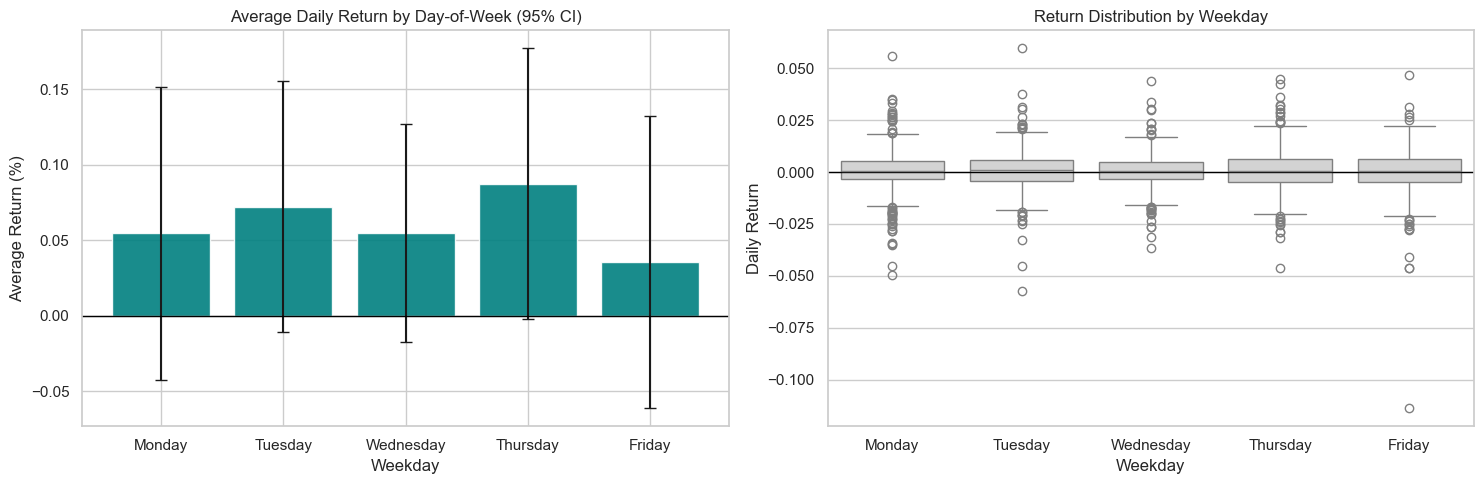

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(
    weekday_stats["Weekday"].astype(str),
    weekday_stats["mean"] * 100,
    yerr=1.96 * weekday_stats["se"] * 100,
    color="teal",
    alpha=0.9,
    capsize=4,
)
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("Average Daily Return by Day-of-Week (95% CI)")
axes[0].set_ylabel("Average Return (%)")
axes[0].set_xlabel("Weekday")

sns.boxplot(data=analysis_df, x="Weekday", y="Return", ax=axes[1], color="lightgray")
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Return Distribution by Weekday")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Daily Return")

plt.tight_layout()
plt.show()

## 5) Month + Year Panel (Stability Across Time)

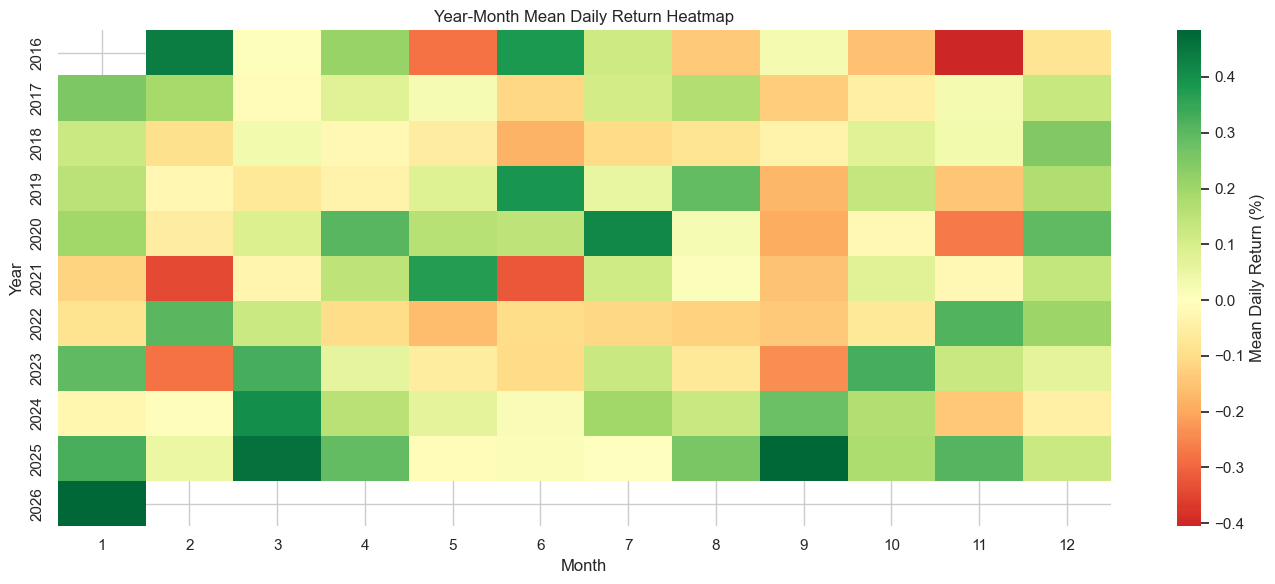

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2022,-0.000849,0.003009,0.001214,-0.000996,-0.001649,-0.000972,-0.001114,-0.001229,-0.001379,-0.000715,0.003156,0.002036
2023,0.002955,-0.002786,0.003293,0.000604,-0.000570,-0.001028,0.001288,-0.000704,-0.002359,0.003293,0.001280,0.000645
2024,-0.000300,-0.000051,0.004068,0.001548,0.000668,0.000173,0.001954,0.001280,0.002799,0.001686,-0.001412,-0.000457
2025,0.003248,0.000497,0.004608,0.002890,-0.000074,0.000139,0.000013,0.002581,0.004833,0.001786,0.003101,0.001226
2026,0.004801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
ym = analysis_df.copy()
ym_group = ym.groupby(["Year", "Month"]) ["Return"].mean().reset_index()
ym_pivot = ym_group.pivot(index="Year", columns="Month", values="Return")

plt.figure(figsize=(14, 6))
sns.heatmap(
    ym_pivot * 100,
    cmap="RdYlGn",
    center=0,
    annot=False,
    cbar_kws={"label": "Mean Daily Return (%)"},
)
plt.title("Year-Month Mean Daily Return Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

ym_pivot.tail(5)

## 6) Statistical Tests: Is Calendar Effect Real?

In [11]:
def bootstrap_mean_diff(x, y, n_boot=3000, rng=None):
    if rng is None:
        rng = np.random.default_rng(42)
    x = np.asarray(x)
    y = np.asarray(y)
    bx = rng.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    by = rng.choice(y, size=(n_boot, len(y)), replace=True).mean(axis=1)
    diff = bx - by
    ci_low, ci_high = np.quantile(diff, [0.025, 0.975])
    p_boot = 2 * min((diff <= 0).mean(), (diff >= 0).mean())
    return float(diff.mean()), float(ci_low), float(ci_high), float(p_boot)


def effect_table(group_col, value_col="Return", n_boot=3000):
    rows = []
    unique_levels = [lv for lv in analysis_df[group_col].dropna().unique()]

    for i, level in enumerate(unique_levels):
        g = analysis_df.loc[analysis_df[group_col] == level, value_col].dropna().values
        r = analysis_df.loc[analysis_df[group_col] != level, value_col].dropna().values

        t_stat, p_val = ttest_ind(g, r, equal_var=False, nan_policy="omit")
        mean_diff = g.mean() - r.mean()
        pooled_std = np.sqrt((g.var(ddof=1) + r.var(ddof=1)) / 2)
        cohen_d = mean_diff / pooled_std if pooled_std > 0 else np.nan

        boot_mean, ci_low, ci_high, p_boot = bootstrap_mean_diff(
            g, r, n_boot=n_boot, rng=np.random.default_rng(1000 + i)
        )

        rows.append({
            "Level": str(level),
            "N_level": len(g),
            "N_rest": len(r),
            "LevelMean": g.mean(),
            "RestMean": r.mean(),
            "MeanDiff": mean_diff,
            "Cohen_d": cohen_d,
            "t_stat": t_stat,
            "p_value": p_val,
            "boot_diff_mean": boot_mean,
            "boot_ci_low": ci_low,
            "boot_ci_high": ci_high,
            "boot_p_value": p_boot,
        })

    out = pd.DataFrame(rows)
    out["p_adj_fdr_bh"] = multipletests(out["p_value"], method="fdr_bh")[1]
    out["significant_5pct"] = out["p_adj_fdr_bh"] < 0.05
    out["ci_excludes_zero"] = (out["boot_ci_low"] > 0) | (out["boot_ci_high"] < 0)
    out = out.sort_values("p_adj_fdr_bh").reset_index(drop=True)
    return out

month_test = effect_table("MonthName", n_boot=3000)
weekday_test = effect_table("Weekday", n_boot=3000)

month_test

,Level,N_level,N_rest,LevelMean,RestMean,MeanDiff,Cohen_d,t_stat,p_value,boot_diff_mean,boot_ci_low,boot_ci_high,boot_p_value,p_adj_fdr_bh,significant_5pct,ci_excludes_zero
0,Feb,187,2322,0.000093,0.000652,-0.000559,-0.055691,-0.732761,0.464495,-0.000580,-0.002143,0.000909,0.442667,0.646041,False,False
1,Mar,219,2290,0.001294,0.000545,0.000749,0.067253,0.872347,0.383874,0.000763,-0.000895,0.002416,0.376667,0.646041,False,False
2,Apr,206,2303,0.001116,0.000565,0.000551,0.052792,0.700135,0.484530,0.000550,-0.001018,0.002077,0.466000,0.646041,False,False
3,May,213,2296,0.000118,0.000656,-0.000538,-0.054577,-0.775693,0.438644,-0.000545,-0.001918,0.000799,0.422000,0.646041,False,False
4,Jun,210,2299,0.000121,0.000655,-0.000534,-0.054388,-0.771257,0.441273,-0.000532,-0.001856,0.000877,0.450000,0.646041,False,False
5,Sep,204,2305,-0.000266,0.000688,-0.000953,-0.101982,-1.514735,0.131066,-0.000969,-0.002201,0.000255,0.121333,0.646041,False,False
6,Nov,204,2305,-0.000161,0.000678,-0.000839,-0.081965,-1.100175,0.272373,-0.000822,-0.002292,0.000676,0.276000,0.646041,False,False
7,Dec,209,2300,0.001246,0.000552,0.000694,0.072901,1.069898,0.285658,0.000704,-0.000515,0.001946,0.269333,0.646041,False,False
8,Jan,203,2306,0.001607,0.000523,0.001084,0.096957,1.210948,0.227188,0.001089,-0.000769,0.002760,0.224000,0.646041,False,False
9,Jul,211,2298,0.000931,0.000581,0.000350,0.038746,0.614064,0.539666,0.000333,-0.000817,0.001461,0.557333,0.647600,False,False


In [12]:
weekday_test

,Level,N_level,N_rest,LevelMean,RestMean,MeanDiff,Cohen_d,t_stat,p_value,boot_diff_mean,boot_ci_low,boot_ci_high,boot_p_value,p_adj_fdr_bh,significant_5pct,ci_excludes_zero
0,Monday,466,2043,0.000545,0.000625,-0.000080,-0.007778,-0.147906,0.882463,-0.000079,-0.001148,0.000985,0.896000,0.882463,False,False
1,Tuesday,517,1992,0.000722,0.000581,0.000140,0.014210,0.292438,0.770024,0.000140,-0.000771,0.001089,0.778000,0.882463,False,False
2,Wednesday,514,1995,0.000550,0.000626,-0.000076,-0.008034,-0.174050,0.861863,-0.000093,-0.000987,0.000744,0.834000,0.882463,False,False
3,Thursday,506,2003,0.000873,0.000544,0.000329,0.032462,0.646307,0.518275,0.000336,-0.000657,0.001314,0.517333,0.882463,False,False
4,Friday,506,2003,0.000355,0.000675,-0.000320,-0.030598,-0.592497,0.553705,-0.000310,-0.001353,0.000753,0.566000,0.882463,False,False


In [13]:
# Global omnibus tests for group-level difference.
month_groups = [g["Return"].values for _, g in analysis_df.groupby("MonthName")]
weekday_groups = [g["Return"].values for _, g in analysis_df.groupby("Weekday")]

anova_month = f_oneway(*month_groups)
kruskal_month = kruskal(*month_groups)
anova_weekday = f_oneway(*weekday_groups)
kruskal_weekday = kruskal(*weekday_groups)

global_tests = pd.DataFrame(
    [
        ["Month", "ANOVA", anova_month.statistic, anova_month.pvalue],
        ["Month", "Kruskal", kruskal_month.statistic, kruskal_month.pvalue],
        ["Weekday", "ANOVA", anova_weekday.statistic, anova_weekday.pvalue],
        ["Weekday", "Kruskal", kruskal_weekday.statistic, kruskal_weekday.pvalue],
    ],
    columns=["Group", "Test", "Statistic", "p_value"],
)

global_tests

,Group,Test,Statistic,p_value
0,Month,ANOVA,0.813463,0.626675
1,Month,Kruskal,11.449433,0.406415
2,Weekday,ANOVA,0.193736,0.941750
3,Weekday,Kruskal,0.179216,0.996217


In [14]:
# Explicit check for September (or any month of interest) vs all other months.
sep = analysis_df.loc[analysis_df["Month"] == 9, "Return"].dropna().values
non_sep = analysis_df.loc[analysis_df["Month"] != 9, "Return"].dropna().values

sep_t = ttest_ind(sep, non_sep, equal_var=False, nan_policy="omit")
sep_boot = bootstrap_mean_diff(sep, non_sep, n_boot=5000, rng=np.random.default_rng(99))

sep_result = pd.Series(
    {
        "Sep_mean_return": sep.mean(),
        "NonSep_mean_return": non_sep.mean(),
        "MeanDiff_Sep_minus_Others": sep.mean() - non_sep.mean(),
        "Welch_t_stat": sep_t.statistic,
        "Welch_p_value": sep_t.pvalue,
        "Bootstrap_diff_mean": sep_boot[0],
        "Bootstrap_CI_low": sep_boot[1],
        "Bootstrap_CI_high": sep_boot[2],
        "Bootstrap_p_value": sep_boot[3],
    }
)
sep_result.to_frame("value")

,value
Sep_mean_return,-0.000266
NonSep_mean_return,0.000688
MeanDiff_Sep_minus_Others,-0.000953
Welch_t_stat,-1.514735
Welch_p_value,0.131066
Bootstrap_diff_mean,-0.000945
Bootstrap_CI_low,-0.002173
Bootstrap_CI_high,0.000299
Bootstrap_p_value,0.126800


## 7) Feature Recommendations for Forecasting

In [15]:
sig_month = month_test[(month_test["p_adj_fdr_bh"] < 0.10) & (month_test["ci_excludes_zero"])].copy()
sig_weekday = weekday_test[(weekday_test["p_adj_fdr_bh"] < 0.10) & (weekday_test["ci_excludes_zero"])].copy()

recommendations = []

# Always include low-cost calendar encodings in benchmark models.
recommendations.append({
    "Feature": "Month dummies (one-hot)",
    "Use": "YES",
    "Reason": "Captures fixed month-of-year seasonality and is low complexity.",
})
recommendations.append({
    "Feature": "Weekday dummies (one-hot)",
    "Use": "YES",
    "Reason": "Captures day-of-week effects with minimal model overhead.",
})
recommendations.append({
    "Feature": "Cyclical month encoding (sin/cos)",
    "Use": "YES",
    "Reason": "Preserves cyclic distance between months (Dec close to Jan).",
})

if len(sig_month) > 0:
    recommendations.append({
        "Feature": "Specific month indicators",
        "Use": "PRIORITY",
        "Reason": f"Evidence of month-level effect after FDR correction in: {', '.join(sig_month['Level'].tolist())}",
    })
else:
    recommendations.append({
        "Feature": "Specific month indicators",
        "Use": "OPTIONAL",
        "Reason": "No strong month-specific significance after multiple-testing correction.",
    })

if len(sig_weekday) > 0:
    recommendations.append({
        "Feature": "Specific weekday indicators",
        "Use": "PRIORITY",
        "Reason": f"Evidence of weekday effect after FDR correction in: {', '.join(sig_weekday['Level'].tolist())}",
    })
else:
    recommendations.append({
        "Feature": "Specific weekday indicators",
        "Use": "OPTIONAL",
        "Reason": "No strong weekday-specific significance after multiple-testing correction.",
    })

recommendation_df = pd.DataFrame(recommendations)
recommendation_df

,Feature,Use,Reason
0,Month dummies (one-hot),YES,Captures fixed month-of-year seasonality and i...
1,Weekday dummies (one-hot),YES,Captures day-of-week effects with minimal mode...
2,Cyclical month encoding (sin/cos),YES,Preserves cyclic distance between months (Dec ...
3,Specific month indicators,OPTIONAL,No strong month-specific significance after mu...
4,Specific weekday indicators,OPTIONAL,No strong weekday-specific significance after ...


In [16]:
# Example model-ready calendar feature block.
calendar_features = analysis_df[["Date", "Close", "Return", "Month", "Weekday"]].copy()
calendar_features = pd.get_dummies(calendar_features, columns=["Month", "Weekday"], drop_first=True)
calendar_features["month_sin"] = np.sin(2 * np.pi * analysis_df["Month"] / 12)
calendar_features["month_cos"] = np.cos(2 * np.pi * analysis_df["Month"] / 12)

print("Calendar feature table shape:", calendar_features.shape)
calendar_features.head()

Calendar feature table shape: (2509, 20)


,Date,Close,Return,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Weekday_Tuesday,Weekday_Wednesday,Weekday_Thursday,Weekday_Friday,month_sin,month_cos
1,2016-02-08,"1,197.900024",0.034635,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.866025,0.500000
2,2016-02-09,"1,198.699951",0.000668,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0.866025,0.500000
3,2016-02-10,"1,194.699951",-0.003337,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0.866025,0.500000
4,2016-02-11,"1,247.900024",0.044530,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.866025,0.500000
5,2016-02-12,"1,239.099976",-0.007052,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0.866025,0.500000


## Final Summary

Interpret the calendar effects using both p-values and effect sizes:
- If significance is weak and effect sizes are small, keep calendar variables as regularized/optional features.
- If specific months or weekdays are consistently significant, prioritize those dummies in forecasting models.
- Validate utility with walk-forward backtests to confirm out-of-sample gain.